In [4]:
!pip install torch torchvision pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 54.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
from pathlib import Path

# Import glob to get the files directories recursively
import glob

# Import Garbage collector interface
import gc

# Import OpenCV to transforme pictures
import cv2

# Import Time
import time

# import numpy for math calculations
import numpy as np

# Import pandas for data (csv) manipulation
import pandas as pd

# Import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight')
%matplotlib inline

import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import pytorch_lightning as pl

# Import pytorch to build Deel Learling Models
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

from torchsummary import summary

# Import tqdm to show a smart progress meter
from tqdm import tqdm

# Import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
color_path = "/content/drive/MyDrive/sih/data/color-scale.npy"
gray_path = "/content/drive/MyDrive/sih/data/gray_scale.npy"

In [55]:
color_df = np.load(color_path)[0:5000]
gray_df = np.load(gray_path)[0:5000]
dataset = (gray_df,color_df )
gc.collect()

60066

# DATA Exploration and visualization

In [56]:
def lab_to_rgb(L, ab):
    """
    Takes an image or a batch of images and converts from LAB space to RGB
    """
    L = L  * 100
    ab = (ab - 0.5) * 128 * 2
    Lab = torch.cat([L, ab], dim=2).numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [57]:
plt.figure(figsize=(30,30))
for i in range(1,16,2):
    plt.subplot(4,4,i)
    img = np.zeros((224,224,3))
    img[:,:,0] = L_df[i]
    plt.title('B&W')
    plt.imshow(lab2rgb(img))

    plt.subplot(4,4,i+1)
    img[:,:,1:] = ab_df[i]
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    plt.title('Colored')
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
gc.collect()

59594

# Data Loader

In [58]:
class ImageColorizationDataset(Dataset):
    ''' Black and White (L) Images and corresponding A&B Colors'''
    def __init__(self, dataset, transform=None):
        '''
        :param dataset: Dataset name.
        :param data_dir: Directory with all the images.
        :param transform: Optional transform to be applied on sample
        '''
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset[0])

    def __getitem__(self, idx):
        L = np.array(dataset[0][idx]).reshape((224,224,1))
        L = transforms.ToTensor()(L)

        ab = np.array(dataset[1][idx])
        ab = transforms.ToTensor()(ab)

        return ab, L

In [59]:
batch_size = 1

# Prepare the Datasets
train_dataset = ImageColorizationDataset(dataset = (L_df, ab_df))
test_dataset = ImageColorizationDataset(dataset = (L_df, ab_df))

# Build DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True, pin_memory = True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = False, pin_memory = True)

# Data Modelling

In [60]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3,padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.identity_map = nn.Conv2d(in_channels, out_channels,kernel_size=1,stride=stride)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, inputs):
        x = inputs.clone().detach()
        out = self.layer(x)
        residual  = self.identity_map(inputs)
        skip = out + residual
        return self.relu(skip)

In [61]:
class DownSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.layer = nn.Sequential(
            nn.MaxPool2d(2),
            ResBlock(in_channels, out_channels)
        )

    def forward(self, inputs):
        return self.layer(inputs)

In [62]:
class UpSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.res_block = ResBlock(in_channels + out_channels, out_channels)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        return x

In [63]:
class Generator(nn.Module):
    def __init__(self, input_channel, output_channel, dropout_rate = 0.2):
        super().__init__()
        self.encoding_layer1_ = ResBlock(input_channel,64)
        self.encoding_layer2_ = DownSampleConv(64, 128)
        self.encoding_layer3_ = DownSampleConv(128, 256)
        self.bridge = DownSampleConv(256, 512)
        self.decoding_layer3_ = UpSampleConv(512, 256)
        self.decoding_layer2_ = UpSampleConv(256, 128)
        self.decoding_layer1_ = UpSampleConv(128, 64)
        self.output = nn.Conv2d(64, output_channel, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, inputs):
        ###################### Enocoder #########################
        e1 = self.encoding_layer1_(inputs)
        e1 = self.dropout(e1)
        e2 = self.encoding_layer2_(e1)
        e2 = self.dropout(e2)
        e3 = self.encoding_layer3_(e2)
        e3 = self.dropout(e3)

        ###################### Bridge #########################
        bridge = self.bridge(e3)
        bridge = self.dropout(bridge)

        ###################### Decoder #########################
        d3 = self.decoding_layer3_(bridge, e3)
        d2 = self.decoding_layer2_(d3, e2)
        d1 = self.decoding_layer1_(d2, e1)

        ###################### Output #########################
        output = self.output(d1)
        return output

In [64]:
model = Generator(1,2).to(device)
summary(model, (1, 224, 224), batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]             576
       BatchNorm2d-2          [1, 64, 224, 224]             128
              ReLU-3          [1, 64, 224, 224]               0
            Conv2d-4          [1, 64, 224, 224]          36,864
       BatchNorm2d-5          [1, 64, 224, 224]             128
              ReLU-6          [1, 64, 224, 224]               0
            Conv2d-7          [1, 64, 224, 224]             128
              ReLU-8          [1, 64, 224, 224]               0
          ResBlock-9          [1, 64, 224, 224]               0
        Dropout2d-10          [1, 64, 224, 224]               0
        MaxPool2d-11          [1, 64, 112, 112]               0
           Conv2d-12         [1, 128, 112, 112]          73,728
      BatchNorm2d-13         [1, 128, 112, 112]             256
             ReLU-14         [1, 128, 1

In [65]:
class Critic(nn.Module):
    def __init__(self, in_channels=3):
        super(Critic, self).__init__()

        def critic_block(in_filters, out_filters, normalization=True):
            """Returns layers of each critic block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *critic_block(in_channels, 64, normalization=False),
            *critic_block(64, 128),
            *critic_block(128, 256),
            *critic_block(256, 512),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, ab, l):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((ab, l), 1)
        output = self.model(img_input)
        return output

In [66]:
model = Critic(3).to(device)
summary(model, [(2, 224, 224), (1, 224, 224)], batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           3,136
         LeakyReLU-2          [1, 64, 112, 112]               0
            Conv2d-3           [1, 128, 56, 56]         131,200
    InstanceNorm2d-4           [1, 128, 56, 56]               0
         LeakyReLU-5           [1, 128, 56, 56]               0
            Conv2d-6           [1, 256, 28, 28]         524,544
    InstanceNorm2d-7           [1, 256, 28, 28]               0
         LeakyReLU-8           [1, 256, 28, 28]               0
            Conv2d-9           [1, 512, 14, 14]       2,097,664
   InstanceNorm2d-10           [1, 512, 14, 14]               0
        LeakyReLU-11           [1, 512, 14, 14]               0
AdaptiveAvgPool2d-12             [1, 512, 1, 1]               0
          Flatten-13                   [1, 512]               0
           Linear-14                   

In [67]:
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [68]:
def display_progress(cond, real, fake, current_epoch = 0, figsize=(20,15)):
    """
    Save cond, real (original) and generated (fake)
    images in one panel
    """
    cond = cond.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)

    images = [cond, real, fake]
    titles = ['input','real','generated']
    print(f'Epoch: {current_epoch}')
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for idx,img in enumerate(images):
        if idx == 0:
            ab = torch.zeros((224,224,2))
            img = torch.cat([images[0]* 100, ab], dim=2).numpy()
            imgan = lab2rgb(img)
        else:
            imgan = lab_to_rgb(images[0],img)
        ax[idx].imshow(imgan)
        ax[idx].axis("off")
    for idx, title in enumerate(titles):
        ax[idx].set_title('{}'.format(title))
    plt.show()

In [69]:
class CWGAN(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=100, display_step=10, lambda_gp=10, lambda_r1=10):
        super().__init__()
        self.save_hyperparameters()

        self.display_step = display_step

        self.generator = Generator(in_channels, out_channels)
        self.critic = Critic(in_channels + out_channels)
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
        self.optimizer_C = optim.Adam(self.critic.parameters(), lr=learning_rate, betas=(0.5, 0.9))
        self.lambda_recon = lambda_recon
        self.lambda_gp = lambda_gp
        self.lambda_r1 = lambda_r1
        self.recon_criterion = nn.L1Loss()
        self.generator_losses, self.critic_losses = [], []

        # Set automatic optimization to False
        self.automatic_optimization = False

    def configure_optimizers(self):
        return [self.optimizer_C, self.optimizer_G]

    def generator_step(self, real_images, conditioned_images):
        self.optimizer_G.zero_grad()
        fake_images = self.generator(conditioned_images)
        recon_loss = self.recon_criterion(fake_images, real_images)
        recon_loss.backward()
        self.optimizer_G.step()
        self.generator_losses.append(recon_loss.item())

    def critic_step(self, real_images, conditioned_images):
        self.optimizer_C.zero_grad()
        fake_images = self.generator(conditioned_images)
        fake_logits = self.critic(fake_images, conditioned_images)
        real_logits = self.critic(real_images, conditioned_images)

        loss_C = real_logits.mean() - fake_logits.mean()

        alpha = torch.rand(real_images.size(0), 1, 1, 1, requires_grad=True).to(device)
        interpolated = (alpha * real_images + (1 - alpha) * fake_images.detach()).requires_grad_(True)
        interpolated_logits = self.critic(interpolated, conditioned_images)

        grad_outputs = torch.ones_like(interpolated_logits, dtype=torch.float32, requires_grad=True)
        gradients = torch.autograd.grad(outputs=interpolated_logits, inputs=interpolated, grad_outputs=grad_outputs, create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(len(gradients), -1)
        gradients_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        loss_C += self.lambda_gp * gradients_penalty

        r1_reg = gradients.pow(2).sum(1).mean()
        loss_C += self.lambda_r1 * r1_reg

        loss_C.backward()
        self.optimizer_C.step()
        self.critic_losses.append(loss_C.item())

    def training_step(self, batch, batch_idx):
        real, condition = batch
        opt1, opt2 = self.optimizers()  # Access the optimizers

        # Perform the critic step
        self.critic_step(real, condition)
        opt2.step()  # Step for critic

        # Perform the generator step
        self.generator_step(real, condition)
        opt1.step()  # Step for generator

        # Log average losses
        gen_mean = sum(self.generator_losses[-self.display_step:]) / self.display_step
        crit_mean = sum(self.critic_losses[-self.display_step:]) / self.display_step

        # Log metrics every display_step epochs
        if self.current_epoch % self.display_step == 0 and batch_idx == 0:
            fake = self.generator(condition).detach()
            torch.save(self.generator.state_dict(), f"ResUnet_{self.current_epoch}.pt")
            torch.save(self.critic.state_dict(), f"PatchGAN_{self.current_epoch}.pt")
            print(f"Epoch {self.current_epoch}: Generator loss: {gen_mean}, Critic loss: {crit_mean}")
            display_progress(condition[0], real[0], fake[0], self.current_epoch)
    def on_train_end(self):
        # Save the final model states
        torch.save(self.generator.state_dict(), "/content/drive/MyDrive/sih/models/ResUnet_final.pt")
        torch.save(self.critic.state_dict(), "/content/drive/MyDrive/sih/models/PatchGAN_final.pt")
        print("Final models saved.")

In [70]:
gc.collect()
cwgan = CWGAN(in_channels = 1, out_channels = 2 ,learning_rate=2e-4, lambda_recon=100, display_step=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type      | Params | Mode 
------------------------------------------------------
0 | generator       | Generator | 8.2 M  | train
1 | critic          | Critic    | 2.8 M  | train
2 | recon_criterion | L1Loss    | 0      | train
------------------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
43.893    Total estimated model params size (MB)
105       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Generator loss: 0.06836761832237244, Critic loss: 0.7815988063812256
Epoch: 0


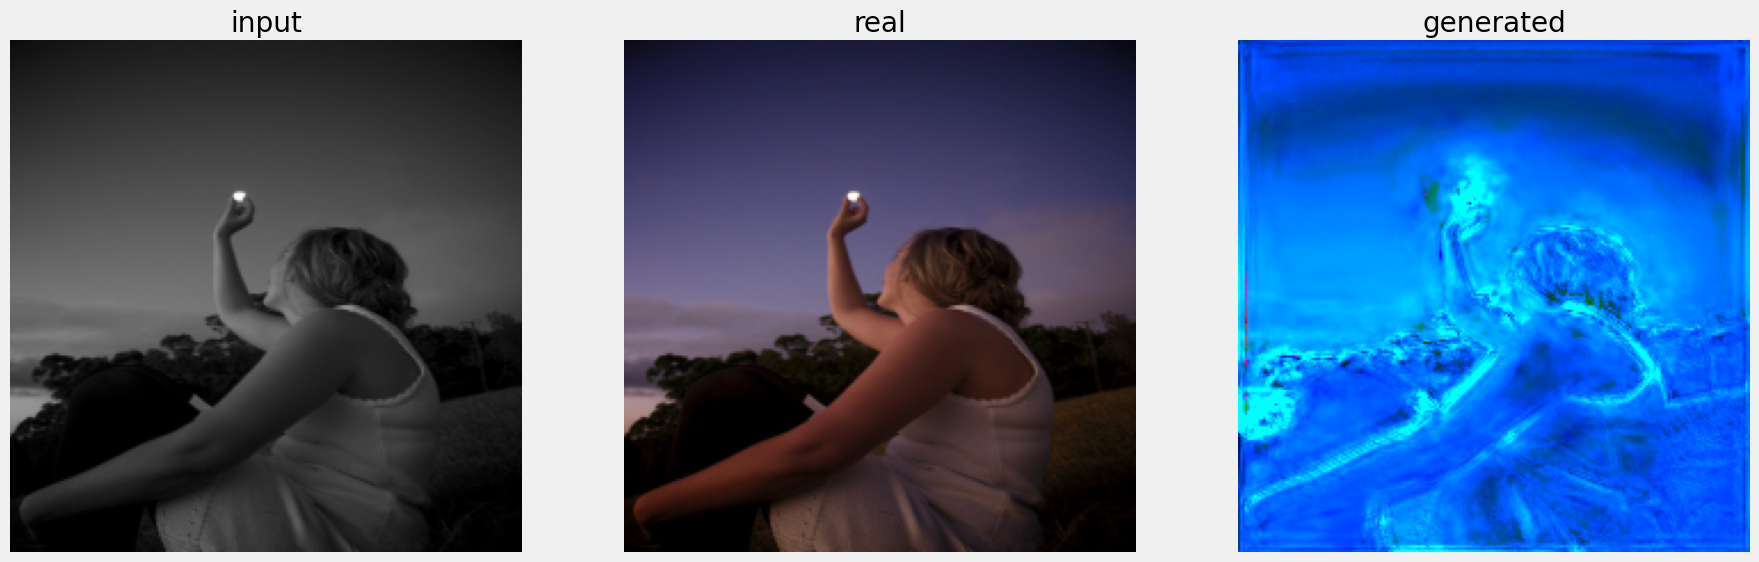

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Final models saved.


In [71]:
trainer = pl.Trainer(max_epochs=100, devices=1, accelerator='gpu')
trainer.fit(cwgan, train_loader)

# Model Inferencing

In [72]:
plt.figure(figsize=(30,60))
idx =1
for batch_idx, batch in enumerate(test_loader):
    real, condition = batch
    pred = cwgan.generator(condition).detach().squeeze().permute(1, 2, 0)
    condition  = condition.detach().squeeze(0).permute(1, 2, 0)
    real  = real.detach().squeeze(0).permute(1, 2, 0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplot(6,3,idx)
    plt.grid(False)

    ab = torch.zeros((224,224,2))
    img = torch.cat([condition * 100, ab], dim=2).numpy()
    imgan = lab2rgb(img)
    plt.imshow(imgan)
    plt.title('Input')

    plt.subplot(6,3,idx + 1)

    ab = torch.zeros((224,224,2))
    imgan = lab_to_rgb(condition,real)
    plt.imshow(imgan)
    plt.title('Real')

    plt.subplot(6,3,idx + 2)
    imgan = lab_to_rgb(condition,pred)
    plt.title('Generated')
    plt.imshow(imgan)
    idx += 3
    if idx >= 18:
        break

Output hidden; open in https://colab.research.google.com to view.

# Evaluation

In [73]:
# disable grads + batchnorm + dropout
torch.set_grad_enabled(False)
cwgan.generator.eval()
all_preds = []
all_real = []

for batch_idx, batch in enumerate(test_loader):
    real, condition = batch
    pred = cwgan.generator(condition).detach()
    Lab = torch.cat([condition, pred], dim=1).numpy()
    Lab_real = torch.cat([condition, real], dim=1).numpy()
    all_preds.append(Lab.squeeze())
    all_real.append(Lab_real.squeeze())
    if batch_idx == 1: break

In [74]:
class InceptionScore:
    def __init__(self, device):
        self.device = device
        self.inception = inception_v3(pretrained=True, transform_input=False).to(self.device)
        self.inception.eval()

    def calculate_is(self, generated_images):
        generated_images = generated_images.to(self.device)

        with torch.no_grad():
            generated_features = self.inception(generated_images.view(-1,3,224,224))

        generated_features = generated_features.view(generated_features.size(0), -1)
        p = F.softmax(generated_features, dim=1)

        kl = p * (torch.log(p) - torch.log(torch.tensor(1.0/generated_features.size(1)).to(self.device)))
        kl = kl.sum(dim=1)

        return kl.mean().item(), kl.std().item()

In [75]:
# Initialize the InceptionScore class
device = "cuda" # or "cpu" if you don't have a GPU
is_calculator = InceptionScore(device)

all_preds = np.concatenate(all_preds, axis=0)
all_preds = torch.tensor(all_preds).float()

all_real = np.concatenate(all_real, axis=0)
all_real = torch.tensor(all_real).float()

is_model = InceptionScore(device)

# Calculate the Inception Score
mean_real, std_real = is_model.calculate_is(all_real)
print("Inception Score of real images: mean: {:.4f}, std: {:.4f}".format(mean_real, std_real))
mean_is, std_is = is_model.calculate_is(all_preds)
print("Inception Score of fake images: mean: {:.4f}, std: {:.4f}".format(mean_is, std_is))

Inception Score of real images: mean: 5.0293, std: 2.6565
Inception Score of fake images: mean: 6.9074, std: 0.0001


## B. Implemenation of Fréchet Inception Distance (FID)

In [76]:
class FID:
    def __init__(self, device):
        self.device = device
        self.inception = inception_v3(pretrained=True, transform_input=False).to(self.device)
        self.inception.eval()
        self.mu = None
        self.sigma = None

    def calculate_fid(self, real_images, generated_images):
        real_images = real_images.to(self.device)
        generated_images = generated_images.to(self.device)

        with torch.no_grad():
            real_features = self.inception(real_images.view(-1,3,224,224))
            generated_features = self.inception(generated_images.view(-1,3,224,224))

        real_features = real_features.view(real_features.size(0), -1)
        generated_features = generated_features.view(generated_features.size(0), -1)

        if self.mu is None:
            self.mu = real_features.mean(dim=0)

        if self.sigma is None:
            self.sigma = real_features.std(dim=0)

        real_mu = real_features.mean(dim=0)
        real_sigma = real_features.std(dim=0)

        generated_mu = generated_features.mean(dim=0)
        generated_sigma = generated_features.std(dim=0)

        mu_diff = real_mu - generated_mu
        sigma_diff = real_sigma - generated_sigma

        fid = mu_diff.pow(2).sum() + (self.sigma - generated_sigma).pow(2).sum() + (self.mu - generated_mu).pow(2).sum()
        return fid.item()

In [77]:
# Initialize the FID class
device = "cuda" # or "cpu" if you don't have a GPU
fid_calculator = FID(device)

# Calculate the FID
fid_value = fid_calculator.calculate_fid(all_real, all_preds)
print("FID: {:.4f}".format(fid_value))

FID: 161264.2812


# Conclusion

In [82]:

# color Halucination


import numpy as np
import torch
from PIL import Image
from skimage.color import lab2rgb
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_image(image_path):
    # Load the image and convert it to grayscale
    img = Image.open(image_path).convert('L')
    img = img.resize((224, 224))  # Resize to match your model input
    L = np.array(img) / 100.0  # Normalize L channel

    # Prepare the tensor
    L_tensor = torch.tensor(L).reshape(1, 1, 224, 224).float().to(device)  # Shape (1, 1, 224, 224)

    return L_tensor

def colorize_image(model, grayscale_image_tensor):
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        # Generate AB channels
        ab_tensor = model(grayscale_image_tensor)

    return ab_tensor


def save_colorized_image(L_tensor, ab_tensor, output_path):
    L = L_tensor.squeeze().cpu().numpy()
    ab = ab_tensor.squeeze().cpu().numpy()

    # Create LAB image
    img_lab = np.zeros((224, 224, 3))
    img_lab[..., 0] = L * 100  # Scale L back
    img_lab[..., 1:] = (ab.transpose(1, 2, 0) * 0.5 + 0.5) * 128  # Rescale AB channels

    # Convert to RGB
    img_rgb = lab2rgb(img_lab)

    # Save the image
    plt.imsave(output_path, img_rgb)

def main(image_path, output_path):
    # Load and preprocess the grayscale image
    grayscale_image_tensor = load_and_preprocess_image(image_path)

    # Move model to the correct device
    model = cwgan.generator.to(device)  # Assuming cwgan.generator is your model

    # Colorize the image
    ab_tensor = colorize_image(model, grayscale_image_tensor)

    # Save the colorized image
    save_colorized_image(grayscale_image_tensor, ab_tensor, output_path)

# Example usage
main("/content/drive/MyDrive/sih/gray.jpg", "/content/drive/MyDrive/sih/colored.png")


In [83]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb

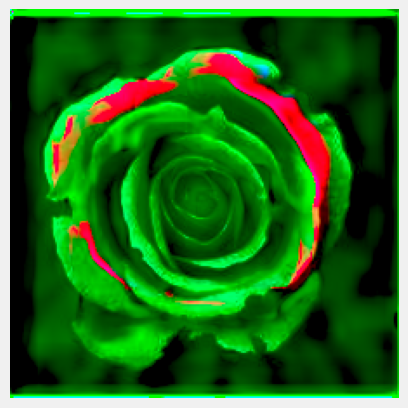

In [81]:
# Load the models
class Generator(nn.Module):
    def __init__(self, input_channel, output_channel, dropout_rate=0.2):
        super().__init__()
        self.encoding_layer1_ = ResBlock(input_channel, 64)
        self.encoding_layer2_ = DownSampleConv(64, 128)
        self.encoding_layer3_ = DownSampleConv(128, 256)
        self.bridge = DownSampleConv(256, 512)
        self.decoding_layer3_ = UpSampleConv(512, 256)
        self.decoding_layer2_ = UpSampleConv(256, 128)
        self.decoding_layer1_ = UpSampleConv(128, 64)
        self.output = nn.Conv2d(64, output_channel, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, inputs):
        # Encoder
        e1 = self.encoding_layer1_(inputs)
        e1 = self.dropout(e1)
        e2 = self.encoding_layer2_(e1)
        e2 = self.dropout(e2)
        e3 = self.encoding_layer3_(e2)
        e3 = self.dropout(e3)

        # Bridge
        bridge = self.bridge(e3)
        bridge = self.dropout(bridge)

        # Decoder with skip connections
        d3 = self.decoding_layer3_(bridge, e3)
        d2 = self.decoding_layer2_(d3, e2)
        d1 = self.decoding_layer1_(d2, e1)

        # Output
        output = self.output(d1)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_model = Generator(input_channel=1, output_channel=2).to(device)
gen_model.load_state_dict(torch.load("/content/drive/MyDrive/sih/models/ResUnet_final.pt"))
gen_model.eval()

# Transform to normalize grayscale image
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing grayscale image to [-1, 1]
])

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Ensure grayscale conversion
    image = transform(image).unsqueeze(0).to(device)
    return image

def lab_to_rgb(L, ab):
    """ Convert LAB to RGB """
    L = L.squeeze(0).cpu().detach().numpy()
    ab = ab.squeeze(0).cpu().detach().numpy()

    # Concatenate L with ab channels
    lab = np.concatenate([L * 100, ab * 128], axis=0).transpose(1, 2, 0)
    rgb = lab2rgb(lab)
    return rgb

def colorize_image(grayscale_image_path):
    # Load and preprocess the grayscale image
    L_channel = load_and_preprocess_image(grayscale_image_path)

    # Generate the ab channels (color information) using the generator model
    with torch.no_grad():
        ab_channels = gen_model(L_channel)

    # Convert LAB to RGB
    rgb_image = lab_to_rgb(L_channel, ab_channels)

    # Display the image
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.show()

# Example usage:
image_path = '/content/drive/MyDrive/sih/gray.jpg'  # Replace with your image path
colorize_image(image_path)
